In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /Users/girasen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/girasen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/girasen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/girasen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
#Loading and splitting the dataset between train and test
org_df=pd.read_csv('Mental_health.csv')
data=org_df.dropna(how='all')
data=data.dropna()
data = data.dropna().reset_index(drop=True)

In [6]:
#Preprocessing of the data
wnl=WordNetLemmatizer()
stop_words=set(stopwords.words('english'))
for i in range(len(data)):
    data.iloc[i,1]=re.sub(r'[^a-zA-Z0-9\s]','',data.iloc[i,1].lower())
    data.iloc[i,1]=re.sub(r'\s',' ',data.iloc[i,1])
    word_tokens=word_tokenize(str(data.iloc[i,1]))
    filtered_stop_words=[x for x in word_tokens if x not in stop_words]
    lemmatized_words=[wnl.lemmatize(x,pos="v") for x in filtered_stop_words]
    data.iloc[i,1]=' '.join(lemmatized_words)

In [7]:
#Building vocabulary list from the dataset
tokenize_words=[word_tokenize(i) for i in data['statement']]
vocabulary=set()
for sentence in tokenize_words:
    vocabulary.update(sentence)
vocab=sorted(list(vocabulary))


In [9]:
# Creating bag of words
def create_bow(sentence,vocab):
    vector=[0]*len(vocab)
    for i in sentence:
        if i in vocab:
            idx=vocab.index(i)
            vector[idx]+=1
    return vector

vectors=[create_bow(sentence,vocab) for sentence in tokenize_words]

In [8]:
#Using TF-IDF vectorization
merged_sentences=[' '.join(i) for i in tokenize_words]
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(merged_sentences)
print("Vocabulary:", tfidf_vectorizer.get_feature_names_out())
print("Array representation:") 
print(X_tfidf.toarray())

Vocabulary: ['00' '10' '10 minutes' ... 'zoloft' 'zombie' 'zone']
Array representation:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
#Creating a  numeric label column
label=[i for i in data['status']]

In [10]:
#Printing unique labels(sentiments) in the data
unique_labels=list(set(label))
print(unique_labels)

['Anxiety', 'Depression', 'Normal', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder']


In [11]:
#Adding a label column
data['label'] = pd.factorize(data['status'])[0]

In [12]:
data.head()

,Unnamed: 0,statement,status,label
0,0,oh gosh,Anxiety,0
1,1,trouble sleep confuse mind restless heart tune,Anxiety,0
2,2,wrong back dear forward doubt stay restless re...,Anxiety,0
3,3,ive shift focus something else im still worry,Anxiety,0
4,4,im restless restless month boy mean,Anxiety,0


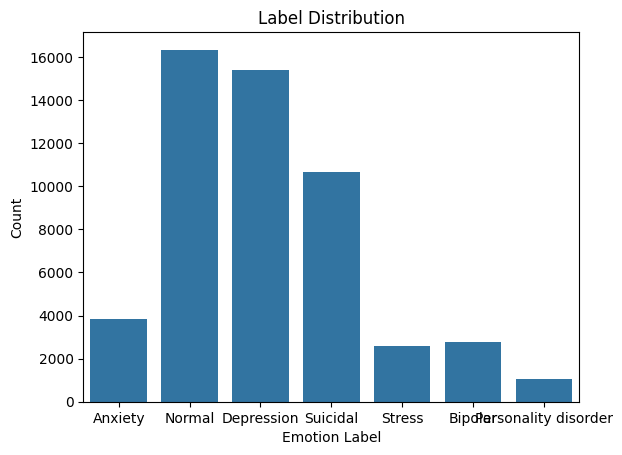

In [17]:
#Bar chart to check if the data is balanced or not
sns.countplot(x='status', data=data)
plt.title('Label Distribution')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.show()


In [18]:
#Implementing SMOTE for balancing the dataset and then splitting it
X=X_tfidf
y=data['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=40)
smote = SMOTE(random_state=40)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train=X_resampled
y_train=y_resampled

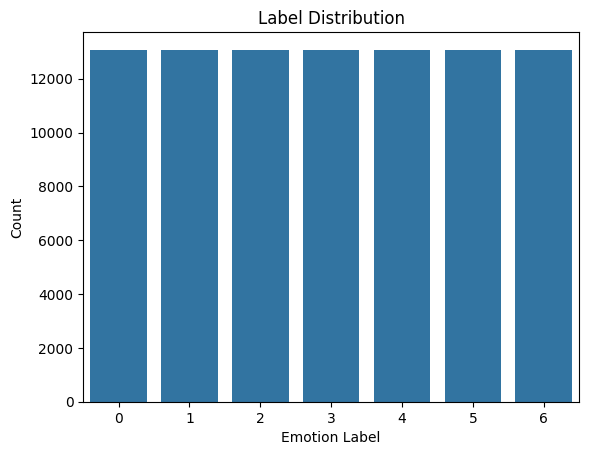

In [19]:
#Bar chart after balancing the dataset
sns.countplot(x=y_train)
plt.title('Label Distribution')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.show()

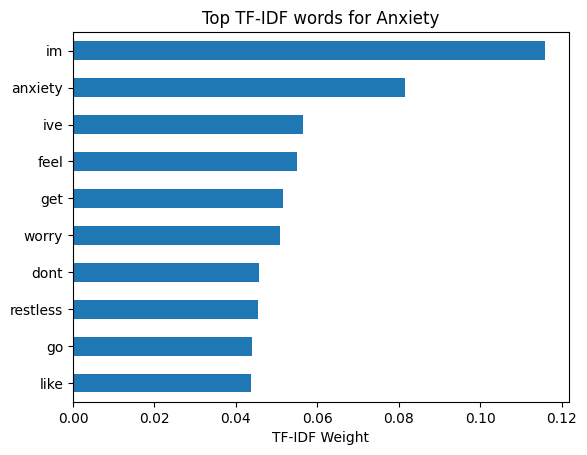

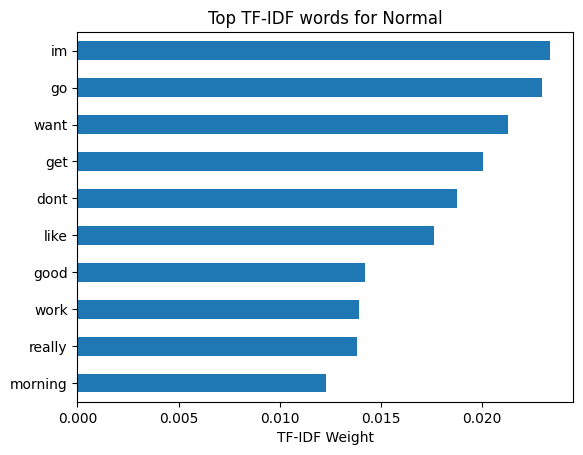

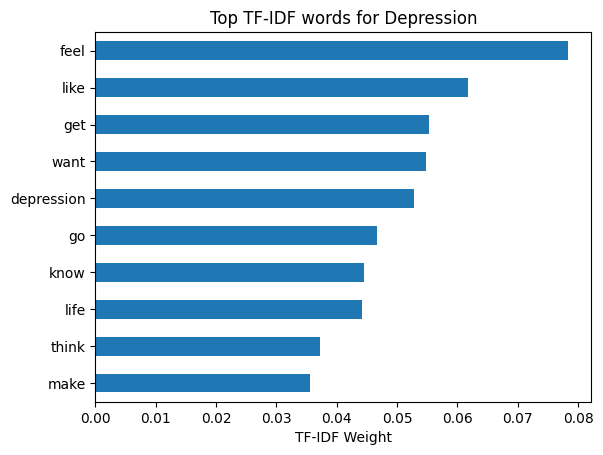

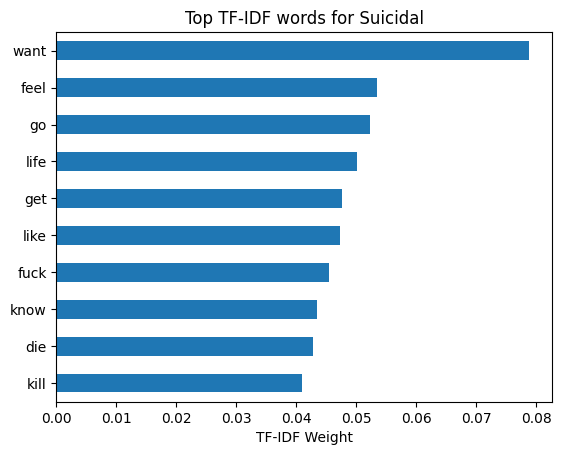

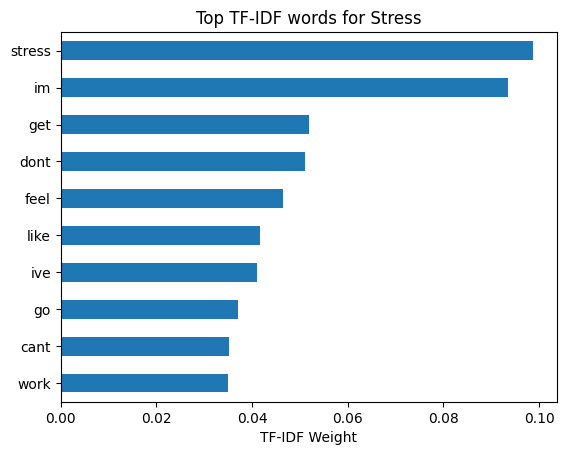

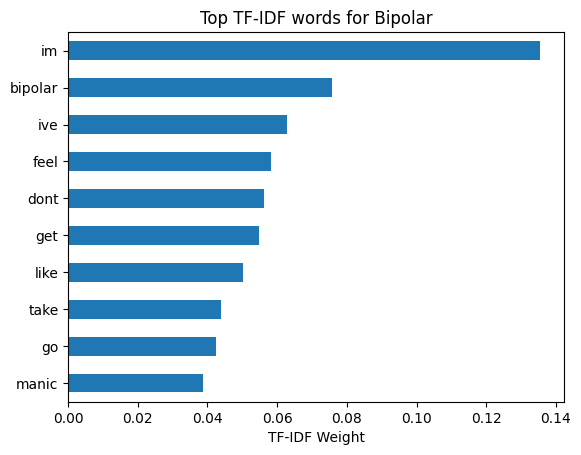

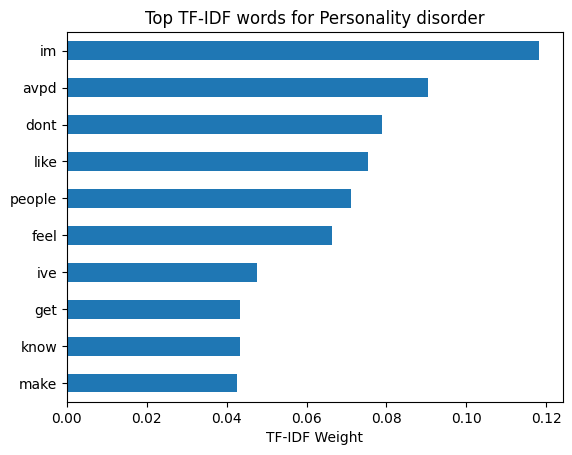

In [23]:
#Frequency of words occurring most frequently across different sentiments

tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(data['statement'])

# Create a DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['label'] = data['status']

# Mean TF-IDF by class
for label in data['status'].unique():
    mean_tfidf = tfidf_df[tfidf_df['label'] == label].drop('label', axis=1).mean().sort_values(ascending=False).head(10)
    mean_tfidf.plot(kind='barh', title=f"Top TF-IDF words for {label}")
    plt.xlabel("TF-IDF Weight")
    plt.gca().invert_yaxis()
    plt.show()


In [20]:
#Implementing Random forest 
rf_model=RandomForestClassifier(n_estimators=100,random_state=40)
#Fit the model for training data
rf_model.fit(X_train,y_train)
#Predict it on the test data
y_pred=rf_model.predict(X_test)

In [21]:
#Accuracy and classification report
accuracy_rep=accuracy_score(y_test,y_pred)
classification_rep=classification_report(y_test,y_pred)
print('Accuracy: ', accuracy_rep)
print('Classification report: ')
print(classification_rep)

Accuracy:  0.745847964316219
Classification report: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       767
           1       0.86      0.91      0.88      3263
           2       0.71      0.69      0.70      3147
           3       0.60      0.62      0.61      2040
           4       0.60      0.54      0.57       541
           5       0.87      0.76      0.81       593
           6       0.84      0.59      0.69       186

    accuracy                           0.75     10537
   macro avg       0.75      0.70      0.72     10537
weighted avg       0.74      0.75      0.74     10537



In [ ]:
rf_model=RandomForestClassifier(n_estimators=100,random_state=40)
#Fit the model for training data
rf_model.fit(X_train,y_train)
#Predict it on the test data
y_pred=rf_model.predict(X_test)

In [ ]:
accuracy_rep=accuracy_score(y_test,y_pred)
classification_rep=classification_report(y_test,y_pred)
print('Accuracy: ', accuracy_rep)
print('Classification report: ')
print(classification_rep)

In [36]:
#Predict a sentence
def predict_sentence(sen):
    sen=re.sub(r'[^a-zA-Z0-9\s]','',sen.lower())
    sen=re.sub(r'\s',' ',sen)
    word_tokens=word_tokenize(sen)
    filtered_stop_words=[x for x in word_tokens if x not in stop_words]
    lemmatized_words=[wnl.lemmatize(x,pos="v") for x in filtered_stop_words]
    sen=' '.join(lemmatized_words)
    return sen
sen=predict_sentence("I am bipolar")
vec_pred = tfidf_vectorizer.transform([sen])
pred_class=rf_model.predict(vec_pred)
print(pred_class)

[1]


In [32]:
#Used logistic regression to compare it with Random Forest
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/girasen/Documents/ML_Personal/mlProjectsVenvTransf/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
y_pred=rf_model.predict(X_test)
accuracy_rep=accuracy_score(y_test,y_pred)
classification_rep=classification_report(y_test,y_pred)
print('Accuracy: ', accuracy_rep)
print('Classification report: ')
print(classification_rep)

Accuracy:  0.745847964316219
Classification report: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       767
           1       0.86      0.91      0.88      3263
           2       0.71      0.69      0.70      3147
           3       0.60      0.62      0.61      2040
           4       0.60      0.54      0.57       541
           5       0.87      0.76      0.81       593
           6       0.84      0.59      0.69       186

    accuracy                           0.75     10537
   macro avg       0.75      0.70      0.72     10537
weighted avg       0.74      0.75      0.74     10537



In [37]:
#Predict a sentence
sen=predict_sentence("I am bipolar")
vec_pred = tfidf_vectorizer.transform([sen])
pred_class=model.predict(vec_pred)
print(pred_class)

[5]


The above implementation shows that eventhough the statement used to predict i.e., 'I am bipolar' and the accuracy for both Random Forest and Logistic Regression is almost same the models end up prediction different labels. This shows that even if models show similar accuracy with the same train and test set, they can predict different labels due to their underlying prediction mecahnism.